# Import necessary modules and packages

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Read the data

In [2]:
%%time
pitches = pd.read_csv('C:/Users/sorin/Desktop/swish/pitches_folder_(1)/pitches_folder/pitches.csv')
# pitches = pd.read_csv('<path to dataset>/pitches.csv')

C:\Users\sorin\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\execution.py:1310: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 7.24 s


In [3]:
len(pitches)

718961

In [4]:
pitches.head()

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,created_at,added_at,modified_at,modified_by
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1


# Objective and initial notes

The goal is to build a model that can predict the probability that the next pitch will be of a particular type, given data about the game situation. There are a few ways to build a **multiclass classification model**, including multinomial logistic regression, and random forest classification.

The dataset contains over 100 fields, including some that are available prior to the pitch being thrown, and some that are not available until after. Since the end goal is to be able to predict a pitch type before the pitch is thrown (possibly in order to place a bet), **only factors that are available before the pitch is thrown will be considered when building the model**.

The dataset may contain cases where the pitch type was a knuckleball. This pitch is a bit different from others, in that knuckleball pitchers (not very common) tend to use them almost exclusively, and all other pitchers pretty much never throw them. With this in mind, **all knuckleball pitchers, and all of their associated pitches, will be removed from the dataset**. Knuckleball pitchers would be better off with their own, separate model (I would recommend a binomial logistic regression, with the possible outcomes being "pitch was a knuckleball" and "pitch was any other pitch").

# Initial data investigation

In [5]:
pitches.describe()

,uid,game_pk,year,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,...,runner6_rbi,runner6_earned,runner7_id,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,modified_by
count,7.189610e+05,718961.000000,718961.0,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,718961.0
mean,1.701980e+07,288557.611823,2011.0,128.787182,128.757296,5.033796,0.508900,39.301513,2.865276,37.357196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,1.665143e+06,3642.210956,0.0,14.281039,14.306711,2.692326,0.499921,23.320725,1.715068,30.690569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,1.414323e+07,286874.000000,2011.0,108.000000,108.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,1.557356e+07,287507.000000,2011.0,115.000000,115.000000,3.000000,0.000000,19.000000,1.000000,11.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,1.703106e+07,288129.000000,2011.0,134.000000,134.000000,5.000000,1.000000,39.000000,3.000000,28.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,1.845894e+07,288749.000000,2011.0,141.000000,141.000000,7.000000,1.000000,58.000000,4.000000,61.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
max,1.983820e+07,317073.000000,2011.0,158.000000,158.000000,19.000000,1.000000,158.000000,16.000000,133.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [6]:
pitches.count()

uid               718961
game_pk           718961
year              718961
date              718961
team_id_b         718961
                   ...  
runner7_earned         0
created_at        718961
added_at          718961
modified_at       718961
modified_by       718961
Length: 125, dtype: int64

## Pitch type dictionary

pitch_dict = {
'AB': '<unknown>'\
'CH': 'Changeup'\
'CU': 'Curveball'\
'EP': 'Eephus'\
'FA': 'Fastball'\
'FC': 'Cutter'\
'FF': 'Four-Seam Fastball'/
'FO': 'Forkball'/
'FS': 'Splitter'/
'FT': 'Two-seam Fastball'/
'IN': 'Intentional Ball'/
'KC': 'Knuckle-curve'/
'KN': 'Knuckleball'/
'PO': 'Pitchout'/
'SC': 'Screwball'/
'SI': 'Sinker'/
'SL': 'Slider'/
'UN': 'Unidentified'\
}

## Count how many times each pitch was thrown throughout the season

In [7]:
# Number of different pitchers that threw at least one pitch, for each pitch type
pitch_counts = pitches['pitch_type'].value_counts().reset_index(name = 'total_pitches')
pitcher_counts_by_type = pitches.groupby('pitch_type')['pitcher_id'].nunique().reset_index(name = 'unique_pitchers')
pitches_combined = pitch_counts.merge(pitcher_counts_by_type, how = 'left', left_on = 'index', right_on = 'pitch_type')
pitches_combined[['pitch_type', 'total_pitches', 'unique_pitchers']]

,pitch_type,total_pitches,unique_pitchers
0,FF,238541,625
1,SL,109756,535
2,SI,87740,204
3,FT,81056,400
4,CH,72641,552
5,CU,56379,372
6,FC,41702,209
7,FS,10503,62
8,KC,8490,38
9,KN,4450,5


In [8]:
# Percentage breakdown for each pitch type
pitches['pitch_type'].value_counts(normalize = True).reset_index()

,index,pitch_type
0,FF,0.332841
1,SL,0.153145
2,SI,0.122425
3,FT,0.113099
4,CH,0.101358
5,CU,0.078667
6,FC,0.058188
7,FS,0.014655
8,KC,0.011846
9,KN,0.006209


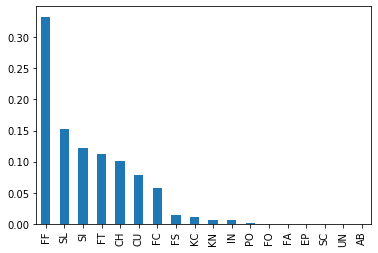

In [9]:
# Plot of pitch type percentages
pitches['pitch_type'].value_counts(normalize = True).plot(kind = 'bar')

In [10]:
# Pitches with <1000 throws, when combined into one pitch type, make up less than 1% of all pitches
pitches['pitch_type'].value_counts(normalize = True).reset_index().loc[11:, 'pitch_type'].sum()

0.0019046130705292872

## Look at knuckleballs

In [11]:
# Count of knuckleballs thrown throughout the season, broken down by pitcher
knuckleballs = pitches[pitches['pitch_type'] == 'KN']
knuckleballs['pitcher_id'].value_counts()

285079    2309
123801    2122
453454       9
211041       8
430574       2
Name: pitcher_id, dtype: int64

In [12]:
# Pitch type breakdowns by knuckleball pitchers
pitches[pitches['pitcher_id'].isin(knuckleballs['pitcher_id'].unique().tolist())][['pitcher_id', 'pitch_type']].value_counts().reset_index(name = 'count').sort_values(['pitcher_id', 'count'], ascending = [True, False])

,pitcher_id,pitch_type,count
1,123801,KN,2122
3,123801,FF,208
7,123801,CU,64
13,123801,PO,15
21,123801,IN,2
4,211041,FF,208
5,211041,SI,82
8,211041,FS,48
9,211041,CU,44
10,211041,SL,42


In [13]:
# Pitch percentage breakdowns for knuckleball pitchers, aggregated
pitches[pitches['pitcher_id'].isin(knuckleballs['pitcher_id'].unique().tolist())]['pitch_type'].value_counts(normalize = True)
# ~74% of pitches by these pitchers are knuckleballs, giving credibility to the
# idea that knuckleball pitchers use this pitch almost exclusively

KN    0.735051
FF    0.189296
CU    0.018500
SI    0.013545
EP    0.013545
FS    0.007929
SL    0.007103
CH    0.006442
PO    0.002973
FC    0.002808
IN    0.002808
Name: pitch_type, dtype: float64

In [14]:
# Percentage breakdown by pitcher (knuckleballs vs. any other pitch type)
kn_pitchers = pitches[pitches['pitcher_id'].isin(knuckleballs['pitcher_id'].unique().tolist())]
kn_pitch_breakdowns = kn_pitchers[['pitcher_id', 'pitch_type']].value_counts().reset_index(name = 'count')
kn_pitch_breakdowns['total_pitches'] = kn_pitch_breakdowns.groupby('pitcher_id')['count'].transform(sum)
kn_pitch_breakdowns['percentage'] = kn_pitch_breakdowns.groupby('pitcher_id')['count'].transform(lambda x: x / sum(x))
kn_pitch_breakdowns = kn_pitch_breakdowns.sort_values(['pitcher_id', 'count'], ascending = [True, False])
kn_pitch_breakdowns[kn_pitch_breakdowns['pitch_type'] == 'KN']
# 211041 seems to be the one exception to the knuckleball exclusitivity idea

,pitcher_id,pitch_type,count,total_pitches,percentage
1,123801,KN,2122,2411,0.880133
16,211041,KN,8,484,0.016529
0,285079,KN,2309,3131,0.737464
22,430574,KN,2,16,0.125000
15,453454,KN,9,12,0.750000


### Conclusion

Knuckleballs make up less than 1% of total pitches thrown throughout the 2011 season. Only 5 different pitchers threw at least one, but for these 5 pitchers, knuckleballs comprised 74% of their total pitches. So, in general, pitchers who throw knuckleballs tend to throw them the majority of the time. These pitchers will not be considered when building the model.

### Do knuckle-curves behave similarly to knuckleballs?

In [15]:
# Count how many knuckle-curves were thrown by each pitcher
knuckle_curves = pitches[pitches['pitch_type'] == 'KC']
knuckle_curves['pitcher_id'].value_counts()
# The answer is no; knuckle-curves are thrown by far more pitchers than are knuckleballs

150359    1084
448306     769
451584     430
450172     399
518886     397
502706     395
460024     389
453178     354
456034     347
461833     278
456701     270
518716     254
502085     253
519186     239
453343     239
477569     232
434442     230
429717     201
474039     198
450306     185
502171     136
502190     130
501957     129
474463     123
501985     121
474699      99
502264      97
472551      96
433586      95
459967      81
476570      43
502046      42
543070      39
519141      32
502748      26
489334      25
449079      18
476454      15
Name: pitcher_id, dtype: int64

# Data filtering

As stated earlier, only fields available prior to each pitch will be used. All other fields will be dropped, except for pitch_type (the dependent variable), and type_confidence (may get used for filtering; see below).

Pitches where type_confidence is low should be thrown out, since for those cases, it is not clear how accurate the labels are. Additionally, along with knuckleballs, pitches where the classification is UN (Unidentified), AB (unknown), or null will be removed.

It is tempting to remove IN (Intentional Ball) and PO (Pitchout), since these are very situational pitches, but they will be kept in the dataset. These pitches are pretty uncommon (the Pitchout especially), so it is unlikely they will affect the model in a harmful way.

Fields involving the date or time of the pitch are likely not relevant to the pitch type, and will not be considered.

## Remove all fields that are not available prior to the pitch (except *pitch_type* and *type_confidence*)

In [16]:
prior_fields = pitches[['uid', 'game_pk', 'year', 'date', 'team_id_b', 'team_id_p', 'inning', 'top',
                        'at_bat_num', 'pcount_at_bat', 'pcount_pitcher',
                        'balls', 'strikes', 'fouls', 'outs',
                        'start_tfs', 'start_tfs_zulu',
                        'batter_id', 'stand', 'b_height', 'pitcher_id', 'p_throws',
                        'away_team_runs', 'home_team_runs', 'pitch_id',
                        'on_1b', 'on_2b', 'on_3b',
                        'pitch_type', 'type_confidence']]

## Remove rows where *pitch_type* is AB, KN (Knuckleball), UN (Unidentified), or null

In [17]:
prior_fields_filtered = prior_fields[(~prior_fields['pitch_type'].isin(['UN', 'AB', 'KN'])) & (prior_fields['pitch_type'].notna())]
prior_fields_filtered['pitch_type'].value_counts(dropna = False)

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
Name: pitch_type, dtype: int64

## Remove pitches where *type_confidence* is low

### Pitch type confidence breakdown by pitch

In [18]:
pitch_type_confidence = prior_fields_filtered[['pitch_type', 'type_confidence']]
pitch_type_confidence.groupby('pitch_type')['type_confidence'].agg(['count', 'min', 'max', 'mean']).sort_values('count', ascending = False).reset_index()
# IN and PO always have type_confidence = 0.0

,pitch_type,count,min,max,mean
0,FF,238541,0.081,2.0,1.404673
1,SL,109756,0.079,2.0,1.507888
2,SI,87740,0.000,2.0,0.988116
3,FT,81056,0.128,2.0,1.419476
4,CH,72641,0.003,2.0,1.557367
5,CU,56379,0.112,2.0,1.538355
6,FC,41702,0.216,2.0,1.507263
7,FS,10503,0.139,2.0,1.665645
8,KC,8490,0.541,2.0,1.992802
9,IN,4058,0.000,0.0,0.000000


### type_confidence breakdown for non-IN/PO pitches

In [19]:
non_in_po_pitches = prior_fields_filtered[~prior_fields_filtered['pitch_type'].isin(['IN', 'PO'])]

In [20]:
non_in_po_pitches['type_confidence'].describe()

count    707595.000000
mean          1.413550
std           0.653432
min           0.000000
25%           0.902000
50%           2.000000
75%           2.000000
max           2.000000
Name: type_confidence, dtype: float64

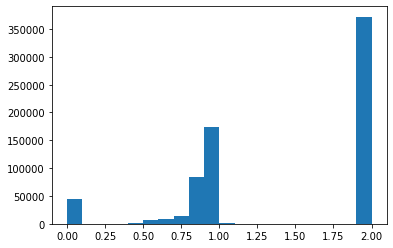

In [21]:
plt.hist(non_in_po_pitches['type_confidence'], bins = 20)
plt.show()

In [22]:
print('Total non-IN/PO pitches:', len(non_in_po_pitches))
print('Number of non-IN/PO pitches where type_confidence < 0.5:', len(non_in_po_pitches[non_in_po_pitches['type_confidence'] < 0.5]))
print('Proportion of total non-IN/PO pitches where type_confidence < 0.5:', len(non_in_po_pitches[non_in_po_pitches['type_confidence'] < 0.5]) / len(non_in_po_pitches))
print('Number of non-IN/PO pitches where type_confidence is 0:', len(non_in_po_pitches[non_in_po_pitches['type_confidence'] == 0]))

Total non-IN/PO pitches: 707595
Number of non-IN/PO pitches where type_confidence < 0.5: 46456
Proportion of total non-IN/PO pitches where type_confidence < 0.5: 0.06565337516517217
Number of non-IN/PO pitches where type_confidence is 0: 44428


In [23]:
print('Proportion of pitches where type_confidence is 2.000:', len(non_in_po_pitches[non_in_po_pitches['type_confidence'] == 2.000]) / len(non_in_po_pitches))

Proportion of pitches where type_confidence is 2.000: 0.5258883966110558


### Rows where *type_confidence* < 0.5 make up ~7% of the data. In nearly all of these rows, *type_confidence* is 0.0.
### All of the rows where *type_confidence* < 0.5 will be removed, except for IN and PO pitches.

In [24]:
prior_fields_confidence = prior_fields_filtered.copy()
prior_fields_confidence = prior_fields_confidence[(prior_fields_confidence['type_confidence'] >= 0.5)
                                                  | (prior_fields_confidence['pitch_type'].isin(['IN', 'PO']))]
len(prior_fields_confidence)

665756

# Data reformatting

Pitches that were thrown <1000 times during the season will be combined into an "Other" (O) pitch type. These pitches make up less than 1% of all pitches in the dataset.

## Combine all pitches with <1000 occurrences into 'Other' group

In [25]:
prior_fields_other = prior_fields_confidence.copy()
prior_fields_other['pitch_type'] = np.where(prior_fields_other['pitch_type'].isin(['PO', 'FO', 'FA', 'EP', 'SC']),
                                            'O',
                                            prior_fields_other['pitch_type'])
prior_fields_other['pitch_type'].value_counts()

FF    237770
SL    109507
FT     80775
CH     72127
CU     56357
SI     43480
FC     41556
FS     10460
KC      8490
IN      4058
O       1176
Name: pitch_type, dtype: int64

## Make *pitcher_id* and *batter_id* into categorical variables

pitcher_id is important to keep, because pitchers often throw the same small group of pitches. There is no reason to place a bet that a pitcher will throw a type of pitch that isn't part of his usual repertoire.

batter_id is also arguably a good field to use, since some batters could be strong against some types of pitches, and weak against others. A good pitcher could take advantage of this.

In [26]:
prior_fields_other.dtypes

uid                  int64
game_pk              int64
year                 int64
date                object
team_id_b            int64
team_id_p            int64
inning               int64
top                  int64
at_bat_num           int64
pcount_at_bat        int64
pcount_pitcher       int64
balls                int64
strikes              int64
fouls                int64
outs                 int64
start_tfs            int64
start_tfs_zulu      object
batter_id            int64
stand               object
b_height            object
pitcher_id           int64
p_throws            object
away_team_runs       int64
home_team_runs       int64
pitch_id             int64
on_1b              float64
on_2b              float64
on_3b              float64
pitch_type          object
type_confidence    float64
dtype: object

In [27]:
prior_fields_ids = prior_fields_other.copy()
prior_fields_ids['pitcher_id'] = prior_fields_ids['pitcher_id'].astype('category')
prior_fields_ids['batter_id'] = prior_fields_ids['batter_id'].astype('category')

In [28]:
prior_fields_ids.dtypes

uid                   int64
game_pk               int64
year                  int64
date                 object
team_id_b             int64
team_id_p             int64
inning                int64
top                   int64
at_bat_num            int64
pcount_at_bat         int64
pcount_pitcher        int64
balls                 int64
strikes               int64
fouls                 int64
outs                  int64
start_tfs             int64
start_tfs_zulu       object
batter_id          category
stand                object
b_height             object
pitcher_id         category
p_throws             object
away_team_runs        int64
home_team_runs        int64
pitch_id              int64
on_1b               float64
on_2b               float64
on_3b               float64
pitch_type           object
type_confidence     float64
dtype: object

## Use *home_team_runs*, *away_team_runs*, and *top* to determine score differential from the pitching team's perspective

The score of the game could affect pitch selection. However, the raw score is not as meaningful as the score differential (ie, a score of 2-1 is effectively equivalent to a score of 10-9), so a new field will be created that pulls the differential from the pitcher's perspective.

In [29]:
prior_fields_run_diff = prior_fields_ids.copy()
prior_fields_run_diff['run_differential'] = np.where(prior_fields_run_diff['top'] == 1,
                                                     prior_fields_run_diff['home_team_runs'] - prior_fields_run_diff['away_team_runs'],
                                                     prior_fields_run_diff['away_team_runs'] - prior_fields_run_diff['home_team_runs'])
prior_fields_run_diff[['game_pk', 'team_id_p', 'inning', 'top', 'home_team_runs', 'away_team_runs', 'run_differential']].drop_duplicates()

,game_pk,team_id_p,inning,top,home_team_runs,away_team_runs,run_differential
26,286874,108,1,0,0,0,0
40,286874,118,2,1,0,0,0
52,286874,108,2,0,0,0,0
65,286874,118,3,1,0,0,0
77,286874,108,3,0,0,0,0
...,...,...,...,...,...,...,...
718902,317073,140,7,0,5,2,-3
718916,317073,140,7,0,6,2,-4
718926,317073,138,8,1,6,2,4
718937,317073,140,8,0,6,2,-4


## Use *inning* to determine number of innings left in the game, including the current inning (minimum 1, ie extra innings are always one inning away from end of game)

The type of pitch could be influenced by how close the game is to its end. Since some games could go longer than 9 innings, using the raw inning number may lead to problems, so a new field is created that calculates how many innings are left to play, with all extra innings being considered the "last" inning.

Note: Games that end in under 9 innings (perhaps due to inclement weather) may lead to inaccuracies, but these will be rare, plus the players can't plan ahead for this.

In [30]:
prior_fields_innings_remaining = prior_fields_run_diff.copy()
prior_fields_innings_remaining['innings_remaining'] = (10 - prior_fields_innings_remaining['inning']).clip(lower = 1)
prior_fields_innings_remaining[['inning', 'innings_remaining']].value_counts().reset_index(name = 'count').sort_values('inning')

,inning,innings_remaining,count
0,1,9,77126
6,2,8,73237
3,3,7,73637
5,4,6,73317
7,5,5,72732
4,6,4,73622
2,7,3,73791
1,8,2,74069
8,9,1,59542
9,10,1,7031


## Use *stand* and *p_throws* to determine if pitcher and batter handedness match

A new (dummy) variable will be created, to determine if the pitcher and batter both have the same handedness, or if they are different.

In [31]:
prior_fields_handedness = prior_fields_innings_remaining.copy()
prior_fields_handedness['handedness_match'] = np.where(prior_fields_handedness['stand'] == prior_fields_handedness['p_throws'],
                                                       1,
                                                       0)
prior_fields_handedness[['stand', 'p_throws', 'handedness_match']].value_counts()

stand  p_throws  handedness_match
R      R         1                   247247
L      R         0                   233427
R      L         0                   130896
L      L         1                    54186
dtype: int64

## Convert *b_height* to inches

Batter height is provided in feet-inches format. It will be converted to an inches format, so that the model can consider it a numeric variable.

In [32]:
prior_fields_height = prior_fields_handedness.copy()
prior_fields_height[['height_ft', 'height_in']] = prior_fields_height['b_height'].str.split('-', expand = True).astype(int)
prior_fields_height['b_height_in'] = (12 * prior_fields_height['height_ft']) + prior_fields_height['height_in']
print(prior_fields_height[['b_height', 'height_ft', 'height_in', 'b_height_in']].drop_duplicates().sort_values('b_height_in'))
prior_fields_height = prior_fields_height.drop(columns = ['height_ft', 'height_in'])

       b_height  height_ft  height_in  b_height_in
424468      5-5          5          5           65
98665       5-6          5          6           66
639119      5-7          5          7           67
65          5-8          5          8           68
402         5-9          5          9           69
26         5-10          5         10           70
359        5-11          5         11           71
45          6-0          6          0           72
39          6-1          6          1           73
95          6-2          6          2           74
363         6-3          6          3           75
40          6-4          6          4           76
379         6-5          6          5           77
391         6-6          6          6           78
3938        6-7          6          7           79
23014       6-8          6          8           80
35650       6-9          6          9           81
17442      6-10          6         10           82


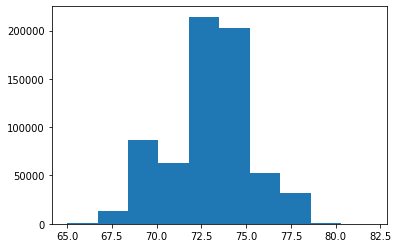

In [33]:
# Plot of batter heights (in inches)
plt.hist(prior_fields_height['b_height_in'])
plt.show()
# There are no outlier heights at either extreme

## Make dummy variables to determine if there are runners on first, second, and third base, using *on_1b*, *on_2b*, and *on_3b*

Players on bases may affect the type of pitch that is thrown. For example, with a runner on 1st, the pitcher may be more likely to throw a fastball or a pitchout, in the event that the runner tries to steal 2nd.

The provided columns *on_1b*, *on_2b*, and *on_3b* give the IDs of the players on each base. Each of these columns will be converted to a simple yes/no dummy variable, indicating if any player is on that base.

In [34]:
prior_fields_runners = prior_fields_height.copy()
prior_fields_runners['runner_1st'] = prior_fields_runners['on_1b'].notna().astype(int)
prior_fields_runners['runner_2nd'] = prior_fields_runners['on_2b'].notna().astype(int)
prior_fields_runners['runner_3rd'] = prior_fields_runners['on_3b'].notna().astype(int)
prior_fields_runners[['runner_1st', 'runner_2nd', 'runner_3rd']].value_counts()

runner_1st  runner_2nd  runner_3rd
0           0           0             377940
1           0           0             120462
0           1           0              56250
1           1           0              44831
            0           1              19484
0           0           1              18028
1           1           1              15174
0           1           1              13587
dtype: int64

# Last minute potential data issues

## Number of balls/strikes/outs

### There are two pitches when there are already 4 balls. This should be impossible.

In [35]:
print(prior_fields_runners['balls'].value_counts())

0    299375
1    200680
2    111961
3     53738
4         2
Name: balls, dtype: int64


### Remove these two pitches from the dataset

In [36]:
prior_fields_cleaned = prior_fields_runners.copy()
prior_fields_cleaned = prior_fields_cleaned[prior_fields_cleaned['balls'] < 4]
print(len(prior_fields_confidence))
print(len(prior_fields_cleaned))

665756
665754


### Strikes and outs do not have this problem

In [37]:
print(prior_fields_cleaned['strikes'].value_counts())
print(prior_fields_cleaned['outs'].value_counts())

0    274932
1    203250
2    187572
Name: strikes, dtype: int64
1    229038
0    225653
2    211063
Name: outs, dtype: int64


### Confirming that all batters begin with 0-0 count

In [38]:
print(prior_fields_cleaned[prior_fields_cleaned['pcount_at_bat'] == 1][['balls', 'strikes', 'fouls']].value_counts())

balls  strikes  fouls
0      0        0        172546
dtype: int64


## Looked at all other fields, and did not see anything out of the ordinary

# Fields to use in the model

## Dependent variable (classifications)

**pitch_type**

## Explanatory variables

**pitcher_id**- unique identifier for pitcher\
**batter_id** - unique identifier for batter\
**b_height_in** - batter height in inches\
**handedness_match** - dummy; 1 if pitcher and batter handedness match, 0 otherwise\
**balls** - raw number of balls prior to pitch\
**strikes** - raw number of strikes prior to pitch\
**outs** - raw number of outs prior to pitch\
**fouls** - raw number of fouls in current at-bat, prior to pitch\
**innings_remaining** - 10 minus current inning (minimum 1)\
**run_differential** - home_team_runs minus away_team_runs\
**pcount_pitcher** - number of pitches thrown by current pitcher throughout the game, prior to current pitch\
**pcount_at_bat** - number of pitches thrown during current at-bat, prior to current pitch\
**runner_1st** - dummy; 1 if there is a runner on 1st base, 0 otherwise\
**runner_2nd** - dummy; 1 if there is a runner on 2nd base, 0 otherwise\
**runner_3rd** - dummy; 1 if there is a runner on 3rd base, 0 otherwise

## The dataset

In [39]:
data = prior_fields_cleaned[['pitcher_id', 'batter_id', 'b_height_in', 'handedness_match',
                             'balls', 'strikes', 'outs', 'fouls',
                             'innings_remaining', 'run_differential',
                             'pcount_pitcher', 'pcount_at_bat',
                             'runner_1st', 'runner_2nd', 'runner_3rd',
                             'pitch_type']]
data.head(10)

,pitcher_id,batter_id,b_height_in,handedness_match,balls,strikes,outs,fouls,innings_remaining,run_differential,pcount_pitcher,pcount_at_bat,runner_1st,runner_2nd,runner_3rd,pitch_type
26,450308,449107,70,1,0,0,0,0,9,0,1,1,0,0,0,FF
27,450308,449107,70,1,0,1,0,0,9,0,2,2,0,0,0,FF
28,450308,449107,70,1,1,1,0,0,9,0,3,3,0,0,0,FF
29,450308,449107,70,1,2,1,0,0,9,0,4,4,0,0,0,FF
30,450308,449107,70,1,2,2,0,1,9,0,5,5,0,0,0,FF
31,450308,449107,70,1,2,2,0,2,9,0,6,6,0,0,0,SL
32,450308,449107,70,1,3,2,0,2,9,0,7,7,0,0,0,FF
33,450308,449107,70,1,3,2,0,3,9,0,8,8,0,0,0,FF
34,450308,449107,70,1,3,2,0,4,9,0,9,9,0,0,0,SL
35,450308,466320,70,0,0,0,1,0,9,0,10,1,0,0,0,FF


In [40]:
data.dtypes

pitcher_id           category
batter_id            category
b_height_in             int32
handedness_match        int32
balls                   int64
strikes                 int64
outs                    int64
fouls                   int64
innings_remaining       int64
run_differential        int64
pcount_pitcher          int64
pcount_at_bat           int64
runner_1st              int32
runner_2nd              int32
runner_3rd              int32
pitch_type             object
dtype: object

## Classification breakdown

In [41]:
# The Four-Seam Fastball (FF) is the most common pitch type by far, with more than double the occurrences of
# the next most common pitch type
data['pitch_type'].value_counts().reset_index(name = 'count').merge(\
data['pitch_type'].value_counts(normalize = True).reset_index(name = 'percent'), on = 'index').rename(\
columns = {'index':'pitch_type'})

,pitch_type,count,percent
0,FF,237769,0.357142
1,SL,109507,0.164486
2,FT,80774,0.121327
3,CH,72127,0.108339
4,CU,56357,0.084651
5,SI,43480,0.065309
6,FC,41556,0.062419
7,FS,10460,0.015712
8,KC,8490,0.012752
9,IN,4058,0.006095


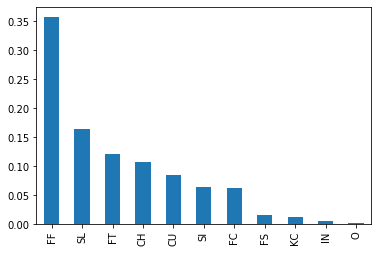

In [42]:
data['pitch_type'].value_counts(normalize = True).plot(kind = 'bar')

## Explanatory variable correlations

In [43]:
data.corr()

,b_height_in,handedness_match,balls,strikes,outs,fouls,innings_remaining,run_differential,pcount_pitcher,pcount_at_bat,runner_1st,runner_2nd,runner_3rd
b_height_in,1.000000,0.061375,0.008628,0.006640,0.025696,0.003415,0.011579,-0.006773,0.012666,0.005733,0.027163,0.014761,0.011294
handedness_match,0.061375,1.000000,-0.028518,0.015200,0.011770,-0.008345,-0.085299,-0.012126,-0.063142,-0.010324,0.019717,0.019371,0.018592
balls,0.008628,-0.028518,1.000000,0.366593,0.019489,0.307152,0.001867,-0.004371,0.030609,0.806972,-0.040466,0.031358,0.017596
strikes,0.006640,0.015200,0.366593,1.000000,-0.005408,0.594704,0.000177,0.010353,0.024976,0.788200,-0.035326,-0.007725,-0.013018
outs,0.025696,0.011770,0.019489,-0.005408,1.000000,-0.006127,-0.006162,-0.055878,0.087458,0.007070,0.152316,0.188532,0.158613
fouls,0.003415,-0.008345,0.307152,0.594704,-0.006127,1.000000,-0.011817,-0.002982,0.043284,0.675978,0.004440,0.014296,0.012400
innings_remaining,0.011579,-0.085299,0.001867,0.000177,-0.006162,-0.011817,1.000000,-0.055921,-0.024544,-0.000936,-0.007057,-0.011290,0.000166
run_differential,-0.006773,-0.012126,-0.004371,0.010353,-0.055878,-0.002982,-0.055921,1.000000,0.098546,0.003806,-0.023868,-0.052761,-0.056937
pcount_pitcher,0.012666,-0.063142,0.030609,0.024976,0.087458,0.043284,-0.024544,0.098546,1.000000,0.035825,0.025930,0.012275,0.004676
pcount_at_bat,0.005733,-0.010324,0.806972,0.788200,0.007070,0.675978,-0.000936,0.003806,0.035825,1.000000,-0.042909,0.015520,0.004191


## The following groups of variables have some association:
Very strong:
- pcount_at_bat and balls/strikes/fouls
    - none of these are surprising; all three of these start at 0, and only increase as pcount_at_bat increases
    - pcount_at_bat should probably be dropped from the model
- balls, strikes, and fouls
    - strikes and fouls is expected; balls and strikes is also expected, though not as much
    - maybe fouls can be dropped from the model

Moderate:
- runner_1st, runner_2nd, and runner_3rd
- outs and runner_1st/runner_2nd/runner_3rd
    - at the start of every inning, there are 0 outs and no runners on any base
       - this was before the rule that puts a runner on 2nd at the start of every extra inning (2020)
    - all of these fields should probably stay in the model

# Modeling

## Split explanatory variables and classification labels into separate Data Frames
## The fields *pcount_at_bat* and *fouls* are removed, due to high correlations with other fields

In [44]:
X = data.drop(columns = ['pitch_type', 'pcount_at_bat', 'fouls'])
y = data['pitch_type']

## Make train and test sets

### In order to test the accuracy of the model, the full dataset will be split into a train set, which will be used to build the model, and a test set, which will be used to see how the model does over a "different" set of data.
### The train/test sets will be a 60/40 split of the full dataset, with rows assigned randomly to one or the other.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 1)

In [46]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

399452
399452
266302
266302


## Model 1: multinomial logistic regression

### Build the model

In [47]:
%%time
# Define the model
model = LogisticRegression(multi_class = 'multinomial', max_iter = 1000000)
# Fit the model to the train set
mlr_model = model.fit(X_train, y_train)

Wall time: 29 s


### Use the model to predict pitch_type in the test set

In [48]:
mlr_model_predictions = mlr_model.predict(X_test)

In [49]:
pd.DataFrame(mlr_model_predictions).value_counts()

FF    266302
dtype: int64

### Model accuracy

In [50]:
print(classification_report(y_test, mlr_model_predictions))

C:\Users\sorin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sorin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          CH       0.00      0.00      0.00     28671
          CU       0.00      0.00      0.00     22539
          FC       0.00      0.00      0.00     16709
          FF       0.36      1.00      0.53     94836
          FS       0.00      0.00      0.00      4134
          FT       0.00      0.00      0.00     32600
          IN       0.00      0.00      0.00      1657
          KC       0.00      0.00      0.00      3421
           O       0.00      0.00      0.00       521
          SI       0.00      0.00      0.00     17440
          SL       0.00      0.00      0.00     43774

    accuracy                           0.36    266302
   macro avg       0.03      0.09      0.05    266302
weighted avg       0.13      0.36      0.19    266302



C:\Users\sorin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
print('Accuracy score:', accuracy_score(y_test, mlr_model_predictions))

Accuracy score: 0.3561219968306659


In [52]:
y_test.value_counts(normalize = True)

FF    0.356122
SL    0.164377
FT    0.122417
CH    0.107663
CU    0.084637
SI    0.065490
FC    0.062745
FS    0.015524
KC    0.012846
IN    0.006222
O     0.001956
Name: pitch_type, dtype: float64

### The model predicts a Four-Seam Fastball (FF) for every pitch. Since that is by far the most common pitch type in the train set, this strategy leads to an overall model accuracy of ~36%, which is the exact percentage of FF pitches in the test set.

## Model 2: multinomial logistic regression with balanced class weights (to account for large discrepancies in pitch_type frequencies)

### Build the model

In [53]:
%%time
# Define the model, using balanced class weights
model_balanced = LogisticRegression(multi_class = 'multinomial', class_weight = 'balanced', max_iter = 1000000)
# Fit the model to the train set
mlr_model_balanced = model_balanced.fit(X_train, y_train)

Wall time: 10.7 s


### Use the model to predict pitch_type in the test set

In [54]:
mlr_model_balanced_predictions = mlr_model_balanced.predict(X_test)

In [55]:
pd.DataFrame(mlr_model_balanced_predictions).value_counts()

FT    97741
KC    84311
FS    58025
CU    26225
dtype: int64

### Model accuracy

In [56]:
print(classification_report(y_test, mlr_model_balanced_predictions))

C:\Users\sorin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sorin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          CH       0.00      0.00      0.00     28671
          CU       0.09      0.11      0.10     22539
          FC       0.00      0.00      0.00     16709
          FF       0.00      0.00      0.00     94836
          FS       0.02      0.32      0.04      4134
          FT       0.13      0.38      0.19     32600
          IN       0.00      0.00      0.00      1657
          KC       0.01      0.34      0.03      3421
           O       0.00      0.00      0.00       521
          SI       0.00      0.00      0.00     17440
          SL       0.00      0.00      0.00     43774

    accuracy                           0.06    266302
   macro avg       0.02      0.10      0.03    266302
weighted avg       0.02      0.06      0.03    266302



C:\Users\sorin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### The balanced class weights overcorrected for the differences in group sizes, and resulted in a model with a very low accuracy of ~6%.

## Model 3: random forest classifier

### Build the model

In [57]:
%%time
# Define the model (with the default 100 trees)
rfc = RandomForestClassifier(random_state = 1)
# Fit the model to the train set
rfc_model = rfc.fit(X_train, y_train)

Wall time: 1min 46s


### Use the model to predict pitch_type in the test set

In [58]:
rfc_model_predictions = rfc_model.predict(X_test)

In [59]:
pd.DataFrame(rfc_model_predictions).value_counts()

FF    164069
SL     36590
CH     21398
FT     15760
CU     10973
SI      7314
FC      6762
IN      1515
FS      1019
KC       814
O         88
dtype: int64

### Model accuracy

In [60]:
print(classification_report(y_test, rfc_model_predictions))

              precision    recall  f1-score   support

          CH       0.26      0.20      0.23     28671
          CU       0.25      0.12      0.17     22539
          FC       0.36      0.14      0.21     16709
          FF       0.42      0.73      0.53     94836
          FS       0.29      0.07      0.11      4134
          FT       0.35      0.17      0.23     32600
          IN       0.75      0.69      0.72      1657
          KC       0.27      0.07      0.11      3421
           O       0.28      0.05      0.08       521
          SI       0.45      0.19      0.26     17440
          SL       0.35      0.29      0.32     43774

    accuracy                           0.39    266302
   macro avg       0.37      0.25      0.27    266302
weighted avg       0.36      0.39      0.35    266302



In [61]:
print('Accuracy score:', accuracy_score(y_test, rfc_model_predictions))

Accuracy score: 0.38740227260779114


### This is the most accurate model of the three (~39%), and it actually guesses each of the different pitch_type values at least a handful of times.
### The model does an especially good job of predicting Intentional Balls (IN), which given how situational that pitch is, isn't very surprising.

### Confusion matrix

In [62]:
# Build the confusion matrix, with actual pitch_type as the rows, and predicted pitch_type as the columns
cm = confusion_matrix(y_test, rfc_model_predictions)
# Convert numbers to recall (correctly predicted pitches of the type divided by total pitches of the type)
cm = cm.astype('float') / cm.sum(axis = 1)
# Relabel the axes
cm = pd.DataFrame(cm, columns = rfc_model.classes_)
cm = cm.rename(index = dict(zip(cm.index, rfc_model.classes_)))
cm

,CH,CU,FC,FF,FS,FT,IN,KC,O,SI,SL
CH,0.197726,0.050756,0.040697,0.167700,0.009434,0.057975,0.039831,0.033031,0.011516,0.041284,0.055741
CU,0.069199,0.123164,0.048297,0.131501,0.017417,0.040307,0.010863,0.002338,0.011516,0.026663,0.059807
FC,0.049946,0.042238,0.144892,0.094858,0.011127,0.022822,0.013277,0.016077,0.005758,0.030963,0.034221
FF,0.186635,0.132792,0.079718,0.729164,0.070150,0.114693,0.082076,0.073663,0.049904,0.052179,0.243432
FS,0.009313,0.009495,0.003950,0.025486,0.070876,0.005644,0.004828,0.000292,0.000000,0.009748,0.011742
FT,0.085103,0.051644,0.026932,0.203109,0.019352,0.168037,0.026554,0.018123,0.023033,0.008716,0.078951
IN,0.001535,0.000799,0.000778,0.003480,0.000242,0.000706,0.687387,0.000000,0.001919,0.000688,0.001736
KC,0.014126,0.001908,0.004070,0.021532,0.000242,0.005644,0.002414,0.065186,0.000000,0.007339,0.007379
O,0.001046,0.000799,0.000539,0.003279,0.000000,0.000828,0.001207,0.000292,0.047985,0.000688,0.001965
SI,0.057759,0.026221,0.027889,0.091790,0.018868,0.010982,0.018105,0.019000,0.001919,0.188016,0.050509


The model has trouble predicting some of the less-common pitch types, such as the Splitter (FS), the Knuckle-curve (KC), and Other (O). It also sometimes confuses Four-Seam Fastballs (FF) with Sliders (SL), which are the two most-common pitch types.

### Feature importance chart

<BarContainer object of 13 artists>

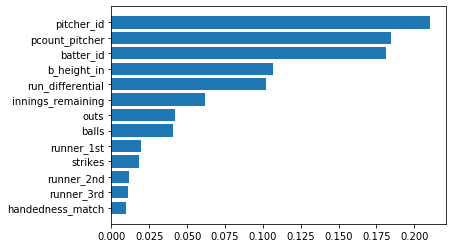

In [63]:
sorted_idx = rfc_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rfc_model.feature_importances_[sorted_idx])

# Create a Data Frame with probabilities for each pitch type

In [64]:
# Get the predicted probabilities for each pitch type for all rows in the test set
probabilities = rfc_model.predict_proba(X_test)
probabilities

array([[0.06, 0.08, 0.05, ..., 0.  , 0.09, 0.18],
       [0.27, 0.07, 0.06, ..., 0.  , 0.22, 0.03],
       [0.05, 0.02, 0.09, ..., 0.  , 0.06, 0.31],
       ...,
       [0.36, 0.11, 0.04, ..., 0.  , 0.03, 0.12],
       [0.06, 0.05, 0.04, ..., 0.  , 0.06, 0.06],
       [0.07, 0.04, 0.03, ..., 0.  , 0.07, 0.26]])

In [65]:
# Combine explanatory variables with pitch_type probabilities
fields_and_probs = X_test.reset_index(drop = True).merge(pd.DataFrame(probabilities, columns = rfc_model.classes_),
                                                         left_index = True, right_index = True)
# Add predicted pitch_type (pitch_type with the highest probability)
fields_and_probs = fields_and_probs.merge(pd.DataFrame(rfc_model_predictions, columns = ['predicted_pitch_type']),
                                          left_index = True, right_index = True)
# Add actual pitch_type
fields_and_probs = fields_and_probs.merge(pd.DataFrame(y_test).reset_index(drop = True).rename(columns = {'pitch_type':'actual_pitch_type'}),
                                          left_index = True, right_index = True)
# Display the probability columns, as well as the predicted and actual pitch_type columns
fields_and_probs.iloc[:, -13:]

,CH,CU,FC,FF,FS,FT,IN,KC,O,SI,SL,predicted_pitch_type,actual_pitch_type
0,0.06,0.08,0.05,0.46,0.00,0.08,0.00,0.00,0.0,0.09,0.18,FF,FF
1,0.27,0.07,0.06,0.26,0.02,0.07,0.00,0.00,0.0,0.22,0.03,CH,SI
2,0.05,0.02,0.09,0.44,0.00,0.03,0.00,0.00,0.0,0.06,0.31,FF,SL
3,0.01,0.07,0.05,0.58,0.00,0.09,0.00,0.00,0.0,0.14,0.06,FF,FT
4,0.05,0.00,0.05,0.29,0.00,0.06,0.49,0.00,0.0,0.06,0.00,IN,IN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
266297,0.09,0.14,0.02,0.27,0.00,0.30,0.02,0.00,0.0,0.14,0.02,FT,CU
266298,0.12,0.06,0.02,0.65,0.00,0.05,0.00,0.00,0.0,0.00,0.10,FF,FF
266299,0.36,0.11,0.04,0.22,0.01,0.10,0.00,0.01,0.0,0.03,0.12,CH,SL
266300,0.06,0.05,0.04,0.51,0.00,0.17,0.04,0.01,0.0,0.06,0.06,FF,FF


In [66]:
# Confirm model accuracy
(fields_and_probs['predicted_pitch_type'] == fields_and_probs['actual_pitch_type']).mean()

0.38740227260779114

# Next steps

## How to improve the model

- Make balls into separate dummy variables.
    - The difference between throwing a ball when there are 0 or 1 balls may be small, but the difference between throwing a ball when there are 2 or 3 balls is much larger.
    - Consider doing something similar for strikes and outs
- If certain runners are more prone to stealing bases than others, then knowing exactly which players are on base could be useful. For example, if the runner on 1st is likely to steal 2nd, then a fastball or pitchout is probably more likely.
    - The gain from doing so in this dataset is probably negligible
- Raise threshold on type_confidence, or only take rows with full confidence
    - This would lead to more confidence that the data is labeled correctly, but would reduce dataset size by nearly half
- Change the train/test split proportions
- Try scaling/standardizing numeric features (such as batter height and pitch count)
    - Ranges in this data are generally small, so gains would probably be small
    - Could result in minor improvements to logistic models
- Experiment with more balancing of pitch_type classifications

## Other notes

- Model may not be good for the upcoming MLB season, due to many rule changes, as well as other evolutions in strategies or pitching techniques
    - Interleague play is far more common now than it was in 2011 (in 2013, the Astros switched to the AL, resulting in an odd number of teams in each league)
    - The addition of pitching timers and pickoff limits have resulted in more stolen base attempts